# Exercise 2: Separate $t$- and $s$-channel contributions

Only Feynman diagrams contributing to the production of $Z$ boson are to be considered for the measurements. The **electron** Monte Carlo sample incorporate contributions from $t$- and $s$-channels.
* Select/correct contributions producing $Z$ boson decays. (Hint: Which role does the $\cos(\theta)$ distribution play in separating $t$- and $s$-channels?)

#### Import libraries and functions

In [1]:
import uproot
import awkward as ak
import mplhep
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad

#### Load the relevant data

In [2]:
### Specify the folder path for MC samples
path_data = 'data/'

### Open the file introducing file path
mc_data_ee = uproot.open(path_data+'ee.root')
ttree_name = 'myTTree'

### Print list of 'branches' of the TTree (i.e. list of variable names)
print(mc_data_ee[ttree_name].keys())

### Load branches
branches_ee = mc_data_ee[ttree_name].arrays()

['run', 'event', 'Ncharged', 'Pcharged', 'E_ecal', 'E_hcal', 'E_lep', 'cos_thru', 'cos_thet']


The last line shows all the variables available in the TTree to carry out the experiment. The meaning of these is described in the following table

| Variable name | Description |
| --- | --- | 
| <pre>run</pre> | Run number |
| <pre>event</pre> | Event number |
| <pre>Ncharged</pre> | Number of charged tracks |
| <pre>Pcharged</pre> | Total scalar sum of track momenta |
| <pre>E_ecal</pre> | Total energy measured in the electromagnetic calorimeter |
| <pre>E_hcal</pre> | Total energy measured in the hadronic calorimete |
| <pre>E_lep</pre> | LEP beam energy (=$\sqrt{s}/2$) |
| <pre>cos_thru</pre> | cosine of the polar angle between beam axis and thrust axis |
| <pre>cos_thet</pre> | cosine of the polar angle between incoming positron and outgoing positive particle |


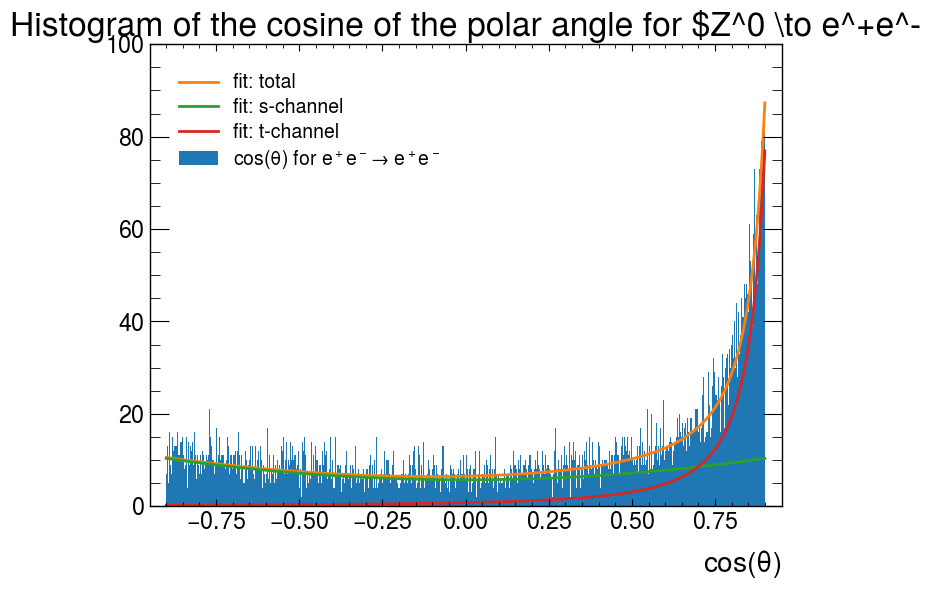

In [3]:
### Make a nice plot of the simulated data
plt.style.use(mplhep.style.ATLAS) # load ATLAS plot style
plt.title(r'Histogram of the cosine of the polar angle for $Z^0 \to e^+e^-')
# Cut of angles 
hbins, hedges, _ = plt.hist(ak.to_numpy(branches_ee['cos_thet']),bins= np.linspace(-0.9,0.9,3000),
         label=r'$\cos(\theta)$ for $e^+e^- \to \ e^+e^-$')

### Fit the cross section for Bhabha scattering (contains a s-channel and a t-channel component)

def bhabha_cross_total(x,S,T):
    return S*(1+x**2)+T/(1-x)**2

def bhabha_cross_S(x,S):
    return S*(1+x**2)

def bhabha_cross_T(x,T):
    return T/(1-x)**2

# # Get the fitted curve
h_mid = 0.5*(hedges[1:] + hedges[:-1]) #Calculate midpoints for the fit


# If we use the points on the edge of the interval, the fit does not work
# start_fit = 10
# mid = -int(len(h_mid)/2)
# end_fit = -10

# coeffs_total, _ = curve_fit(bhabha_cross_total, h_mid[start_fit:end_fit], hbins[start_fit:end_fit],sigma=np.sqrt(hbins[start_fit:end_fit]), maxfev=2000)
# plt.plot(h_mid, bhabha_cross_total(h_mid, *coeffs_total), label='fit: total')

# coeffs_S, _ = curve_fit(bhabha_cross_S, h_mid[start_fit:mid], hbins[start_fit:mid],sigma=np.sqrt(hbins[start_fit:mid]), maxfev=2000)
# plt.plot(h_mid, bhabha_cross_S(h_mid,*coeffs_S), label='fit: s-channel')
# coeffs_T, _ = curve_fit(bhabha_cross_T, h_mid[mid:end_fit], hbins[mid:end_fit],sigma=np.sqrt(hbins[mid:end_fit]), maxfev=2000)
# plt.plot(h_mid, bhabha_cross_T(h_mid,*coeffs_T), label='fit: t-channel')

coeffs, _ = curve_fit(bhabha_cross_total, h_mid, hbins,sigma=np.sqrt(hbins), maxfev=2000)
plt.plot(h_mid, bhabha_cross_total(h_mid, *coeffs), label='fit: total')
plt.plot(h_mid, bhabha_cross_S(h_mid,coeffs[0]), label='fit: s-channel')
plt.plot(h_mid, bhabha_cross_T(h_mid,coeffs[1]), label='fit: t-channel')


plt.xlim(-0.95,0.95)
plt.ylim(0,100)
plt.xlabel(r'$\cos(\theta)$')
plt.legend()
plt.show()

#### Determine the cut
Calculate the intersection point of the obtained curves, and define this point as cut

In [4]:
# Calculate intersection of the s and t channel fit. This defines the cut
idx = np.argwhere(np.diff(np.sign(bhabha_cross_S(h_mid,coeffs[0]) - bhabha_cross_T(h_mid,coeffs[1])))).flatten()
cut = h_mid[idx[0]]
print(cut)

0.6980326775591864


As one can see in the graph, this cuts off some s-channel events $\in \{ \cos(\theta) \in ($cut$,0.9)\}$. But some t- channel events are included on the other hand. In order to calculate the efficiency, we integrate the histogram to the cut (=I_cut), integrate the s-channel curve over (-0.9,0.9) (=I_0), and the t-channel curve (=I_1) over (-0.9,cut) and use the following formular:
\begin{align}
\varepsilon_\text{es} = \frac{I_\text{cut} - I_1}{I_0}
\end{align}

In [5]:
i=0;
I_cut =0;
I_cut_error = 0;
while hedges[i+1] <= cut:
    I_cut += hbins[i]*(hedges[i+1]-hedges[i])
    I_cut_error += (np.sqrt(hbins[i])*(hedges[i+1]-hedges[i]))**2
    i+=1;

I_cut_error = np.sqrt(I_cut_error)
print(f'Integral I_cut:: {I_cut} +/- {I_cut_error}')

Integral I_cut:: 15.048816272090704 +/- 0.0950384160752791


In [6]:
#  Integrate bhabha_cross_S from cos(theta) in (-1.0,1.0)
I_0=quad(bhabha_cross_S, -0.9, 0.9,args=coeffs[0])
print(f'Integral I_0: {I_0[0]} +/- {I_0[1]}')

Integral I_0: 13.088834805998216 +/- 1.4531525767134362e-13


In [7]:
#  Integrate bhabha_cross_S from cos(theta) in (-1.0,1.0)
I_1=quad(bhabha_cross_T, -0.9, cut,args=coeffs[1])
print(f'Integral I_1: {I_1[0]} +/- {I_1[1]}')

Integral I_1: 2.1557192712881577 +/- 7.306874847898688e-10


In [8]:
efficiency_es= (I_cut-I_1[0])/I_0[0]
efficiency_es_error = np.sqrt((I_cut_error/I_0[0])**2 + (I_1[1]/I_0[0])**2 +(((I_cut-I_1[0])*I_0[1])/I_0[0]**2)**2)
print('Correction factor: %.3f +/- %.3f'%(efficiency_es,efficiency_es_error))

Correction factor: 0.985 +/- 0.007


In [9]:
s_selection = np.array([cut,efficiency_es,efficiency_es_error])
np.save(path_data+'s_selection',s_selection)